In [1]:
import os
import torch
import numpy as np
import imageio
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from time import time as time

from sklearn.metrics import confusion_matrix
import torchnet as tnt
import functools

import mock
from tqdm import tqdm_notebook as tqdm


# GLOBAL SETTINGS
PlotSize = 8                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = matplotlib.colors.ListedColormap(['black', 'white', 'orange'])               # Color mapping 
np.set_printoptions(precision=2, suppress=True)  # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names = ['BACKGRD','PINUS','PICEA']
feature_names = ['NIR','RED','GREEN']
num_classes = len(class_names)
num_features = len(feature_names)

# PATHS TO TRAIN/TEST DATA
data_path = '../data/split_05__05/'
training_set_path = data_path + 'train/'         # Relative path to training patch root folder
test_set_path =     data_path + 'test/'          # Relative path to test patch root folder

num_of_training_tiles = len(os.listdir(training_set_path + 'GT/'))
num_of_test_tiles = len(os.listdir(test_set_path + 'GT/'))

# USE CIR OR RGB DATA
use_cir = True
use_rgb = True

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

True
1
GeForce 940MX
(5, 0)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B 

In [10]:
def read_patch(root_folder, cir=True, rgb=True):
    ##########################################################
    # READ IMAGES as FLOAT
    
    if cir:
        cir_file_list = os.listdir(root_folder + 'CIR/')
        cir_list = []
        
        for file in cir_file_list:
            cir_patch = imageio.imread(root_folder + 'CIR/' + file).astype(np.float32)
    
            cir_list.append(cir_patch[:,:,:].transpose([2,0,1]))
            del cir_patch

        cir_features = np.stack(cir_list, axis=0)
    
    
    if rgb:
        rgb_file_list = os.listdir(root_folder + 'RGB/')
        rgb_list = []
        
        for file in rgb_file_list:
            rgb_patch = imageio.imread(root_folder + 'RGB/' + file).astype(np.float32)
    
            rgb_list.append(rgb_patch[:,:,:].transpose([2,0,1]))
            del rgb_patch
        
        rgb_features = np.stack(rgb_list, axis=0)


    gt_file_list = os.listdir(root_folder + 'GT/')
    gt_list = []

    for file in gt_file_list:
        gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.int64)
 
        gt_list.append(gt_patch[:,:])
        del gt_patch

    
    if cir and rgb:
        features = np.concatenate([cir_features, rgb_features], axis=1)
    elif cir:
        features = cir_features
    elif rgb:
        features = rgb_features
    else:
        print('No valid data input.')
    
    ground_truth = np.stack(gt_list, axis=0)

    features = torch.from_numpy(features)
    ground_truth = torch.from_numpy(ground_truth)
    
    ########################################################## 
    return features, ground_truth

In [11]:
#putting the dataset into the TensorDataset wrapper
X, y = read_patch(training_set_path, use_cir, use_rgb)
X_t, y_t = read_patch(test_set_path, use_cir, use_rgb)

print(X.shape)
print(X_t.shape)

train_set = tnt.dataset.TensorDataset(list([X, y]))
test_set  = tnt.dataset.TensorDataset(list([X_t, y_t]))
print(len(train_set))

torch.Size([20, 6, 500, 500])
torch.Size([20, 6, 500, 500])
20


In [5]:
class ConfusionMatrix:
    def __init__(self, n_class, class_names):
        self.CM = np.zeros((n_class, n_class))
        self.n_class = n_class
        self.class_names = class_names
  
    def clear(self):
        self.CM = np.zeros((self.n_class, self.n_class))
    
    def add_batch(self, gt, pred):
        self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
    def overall_accuracy(self):#percentage of correct classification
        return 100*self.CM.trace() / self.CM.sum()

    def class_IoU(self, show = 1):
        ious = np.full(self.n_class, 0.)
        for i_class in range(self.n_class):
            ious[i_class] = self.CM[i_class, i_class] / \
                (-self.CM[i_class, i_class] \
                + self.CM[i_class, :].sum()
                + self.CM[:, i_class].sum())
        if show:
            print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
        #do not count classes that are not present in the dataset in the mean IoU
        return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [ ]:
m = ConfusionMatrix(3, class_names)
m.add_batch(np.array([0,1,1,1,2,0,0,2,0,2,1]), np.array([0,1,0,0,2,0,1,2,0,2,1]))
m.add_batch(np.array([0,1,2,1,2,1,0,2,1]), np.array([0,1,1,1,2,1,0,2,0]))
print(m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()
m.clear()

In [6]:
class SegNet(nn.Module):
    """
    SegNet network for semantic segmentation
    """
  
    def __init__(self, n_channels, encoder_conv_width, decoder_conv_width, n_class, cuda = 0):
        """
        initialization function
        n_channels, int, number of input channel
        encoder_conv_width, int list, size of the feature maps of convs for the encoder
        decoder_conv_width, int list, size of the feature maps of convs for the decoder
        n_class = int,  the number of classes
        """
        super(SegNet, self).__init__() #necessary for all classes extending the module class
    
        assert((encoder_conv_width[3] == encoder_conv_width[5]) \
            and (encoder_conv_width[1] == decoder_conv_width[1]))
    
        self.maxpool=nn.MaxPool2d(2,2,return_indices=True) #maxpooling layer
        self.unpool=nn.MaxUnpool2d(2,2) #unpooling layer
    
        #encoder
        self.c1 = nn.Sequential(nn.Conv2d(n_channels,encoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[0]),nn.ReLU(True))
        self.c2 = nn.Sequential(nn.Conv2d(encoder_conv_width[0],encoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[1]),nn.ReLU(True))
        self.c3 = nn.Sequential(nn.Conv2d(encoder_conv_width[1],encoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[2]),nn.ReLU(True))
        self.c4 = nn.Sequential(nn.Conv2d(encoder_conv_width[2],encoder_conv_width[3],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[3]),nn.ReLU(True))
        self.c5 = nn.Sequential(nn.Conv2d(encoder_conv_width[3],encoder_conv_width[4],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[4]),nn.ReLU(True))
        self.c6 = nn.Sequential(nn.Conv2d(encoder_conv_width[4],encoder_conv_width[5],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[5]),nn.ReLU(True))
        #decoder
        self.c7=nn.Sequential(nn.Conv2d(encoder_conv_width[5]+encoder_conv_width[3],decoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[0]),nn.ReLU(True))
        self.c8=nn.Sequential(nn.Conv2d(decoder_conv_width[0],decoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[1]),nn.ReLU(True))       
        self.c9=nn.Sequential(nn.Conv2d(encoder_conv_width[1] + decoder_conv_width[1],decoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[2]),nn.ReLU(True))
        self.c10=nn.Sequential(nn.Conv2d(decoder_conv_width[2],decoder_conv_width[3],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[3]),nn.ReLU(True))
        #final classifying layer
        self.classifier=nn.Conv2d(decoder_conv_width[3],n_class,3,padding=1, padding_mode='reflect')

        #weight initialization

        self.c1[0].apply(self.init_weights)
        self.c2[0].apply(self.init_weights)
        self.c3[0].apply(self.init_weights)
        self.c4[0].apply(self.init_weights)
        self.c5[0].apply(self.init_weights)
        self.c6[0].apply(self.init_weights)
        self.c7[0].apply(self.init_weights)
        self.c8[0].apply(self.init_weights)
        self.c9[0].apply(self.init_weights)
        self.c10[0].apply(self.init_weights)
        self.classifier.apply(self.init_weights)
    
        if cuda: #put the model on the GPU memory
            self.cuda()
    
    def init_weights(self,layer): #gaussian init for the conv layers
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self,input):
        """
        the function called to run inference
        """  
        #encoder
        #level 1
        x1 = self.c2(self.c1(input))
        x2, indices_a_b =self.maxpool(x1)
        #level 2
        x3=self.c4(self.c3(x2))
        x4, indices_b_c =self.maxpool(x3)
        #level 3
        x5 = self.c6(self.c5(x4))
        #decoder
        #level 2       
        y4 = self.unpool(x5, indices_b_c)
        y3 = self.c8(self.c7(torch.cat((y4,x3),1)))
        #level 1       
        y2 = self.unpool(y3, indices_a_b)
        y1 = self.c10(self.c9(torch.cat((y2,x1),1)))
        #output         
        out = self.classifier(y1)
    
        return out
    
    """
    #encoder
    self.c1 = nn.Sequential(nn.Conv2d(n_channels,encoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[0]),nn.ReLU(True))
    self.c2 = nn.Sequential(nn.Conv2d(encoder_conv_width[0],encoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[1]),nn.ReLU(True))
    self.c3 = nn.Sequential(nn.Conv2d(encoder_conv_width[1],encoder_conv_width[2],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[2]),nn.ReLU(True))
    self.c4 = nn.Sequential(nn.Conv2d(encoder_conv_width[2],encoder_conv_width[3],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(encoder_conv_width[3]),nn.ReLU(True))
    
    self.c9=nn.Sequential(nn.Conv2d(encoder_conv_width[1] + encoder_conv_width[3],decoder_conv_width[0],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[0]),nn.ReLU(True))
    self.c10=nn.Sequential(nn.Conv2d(decoder_conv_width[0],decoder_conv_width[1],3,padding=1, padding_mode='reflect'),nn.BatchNorm2d(decoder_conv_width[0]),nn.ReLU(True))
    #final classifying layer
    self.classifier=nn.Conv2d(decoder_conv_width[1],n_class,3,padding=1, padding_mode='reflect')

    #weight initialization

    self.c1[0].apply(self.init_weights)
    self.c2[0].apply(self.init_weights)
    self.c3[0].apply(self.init_weights)
    self.c4[0].apply(self.init_weights)
    self.c9[0].apply(self.init_weights)
    self.c10[0].apply(self.init_weights)
    self.classifier.apply(self.init_weights)
    
    if cuda: #put the model on the GPU memory
      self.cuda()
    
  def init_weights(self,layer): #gaussian init for the conv layers
    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
  def forward(self,input):

    #encoder
    #level 1
    x1 = self.c2(self.c1(input))
    x2, indices_a_b =self.maxpool(x1)
    #level 2
    x3=self.c4(self.c3(x2))
    
    #decoder
    #level 1       
    y2 = self.unpool(x3, indices_a_b)
    y1 = self.c10(self.c9(torch.cat((y2,x1),1)))
    #output         
    out = self.classifier(y1)
    return out"""

In [ ]:
#we consider the first point cloud from the training set
tile, gt = read_patch(training_set_path)
print(tile.shape)
print(gt.shape)
print(tile[0:2,:,:,:].shape)
segnet = SegNet(3,[4,4,4,4,4,4], [4,4,4,4],3)
print(segnet)
print('Total number of parameters: {}'.format(sum([p.numel() for p in segnet.parameters()])))
pred = segnet(tile[0:2,:,:,:]) #the None indicate a batch size of 1
assert(pred.shape == torch.Size([2,3,500,500]))


In [ ]:
loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)

for index, (tiles, gt) in enumerate(loader):
    print(index)
    print(tiles.shape)
    print(gt.shape)

In [7]:
def train(model, optimizer, args):
  """train for one epoch"""
  model.train() #switch the model in training mode
  
  #the loader function will take care of the batching
  loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  #tqdm will provide some nice progress bars
  loader = tqdm(loader, ncols=500)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  for index, (tiles, gt) in enumerate(loader):
    
    optimizer.zero_grad() #put gradient to zero
    
    pred = model(tiles) #compute the prediction

    loss = nn.functional.cross_entropy(pred,gt, weight=torch.tensor([0.1,0.3,0.6]))

    loss.backward() #compute gradients

    for p in model.parameters(): #we clip the gradient at norm 1
      p.grad.data.clamp_(-1, 1) #this helps learning faster
    
    optimizer.step() #one SGD step
    
    loss_meter.add(loss.item())
    labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
    #need to put the prediction back on the cpu and convert to numpy
    cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())
    
  return cm, loss_meter.value()[0]

def eval(model, args):
  """eval on test/validation set"""
  
  model.eval() #switch in eval mode
  
  loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  
  loader = tqdm(loader, ncols=500)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrix(args.n_class, class_names = class_names)

  with torch.no_grad():
    for index, (tiles, gt) in enumerate(loader):
      
      #TODO
      pred = model(tiles)
      loss = nn.functional.cross_entropy(pred,gt)
      loss_meter.add(loss.item())
      labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
      cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].detach().numpy())

  return cm, loss_meter.value()[0]


def train_full(args):
  """The full training loop"""
  #initialize the model
  
  model = SegNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)

  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
  #define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=args.lr)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,90], gamma=0.7)
  
  TESTCOLOR = '\033[104m'
  TRAINCOLOR = '\033[100m'
  NORMALCOLOR = '\033[0m'
  
  training_accu=[]
  training_miou=[]
  training_loss=[]
  training_epoch=[]
  test_accu=[]
  test_miou=[]
  test_loss=[]
  test_epoch=[]

  for i_epoch in range(args.n_epoch):
    #train one epoch
    cm_train, loss_train = train(model, optimizer, args)
    scheduler.step()
    print(TRAINCOLOR)
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train) + NORMALCOLOR)
    training_epoch.append(i_epoch)
    training_accu.append(cm_train.overall_accuracy())
    training_miou.append(cm_train.class_IoU())
    training_loss.append(loss_train)

    if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
      #periodic testing
      cm_test, loss_test = eval(model, args)
      print(TESTCOLOR)
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
      test_epoch.append(i_epoch)
      test_accu.append(cm_test.overall_accuracy())
      test_miou.append(cm_test.class_IoU())
      test_loss.append(loss_test)
      #viewer(n_shown = 1, train = False, model = model, category = 'cigpe', use_mask = False)

  plt.figure(figsize=(30, 10))
  plt.subplot(1,3,1, ylim=(0,100), xlabel="# of epochs", ylabel="Overall Accuracy")
  plt.plot(training_epoch, training_accu)
  plt.plot(test_epoch, test_accu)
  plt.subplot(1,3,2, ylim=(0,100), xlabel="# of epochs", ylabel="mean Class IoU")
  plt.plot(training_epoch, training_miou)
  plt.plot(test_epoch, test_miou)
  plt.subplot(1,3,3, ylim=(0,1), xlabel="# of epochs", ylabel="Loss function")
  plt.plot(training_epoch, training_loss)
  plt.plot(test_epoch, test_loss)
  plt.show()
  return model

In [8]:
def train(model, optimizer, args):
    """train for one epoch"""
    model.train() #switch the model in training mode
  
    #the loader function will take care of the batching
    loader = torch.utils.data.DataLoader(train_set, \
         batch_size=args.batch_size, shuffle=True, drop_last=True)
  
    #will keep track of the loss
    loss_meter = tnt.meter.AverageValueMeter()

    for index, (tiles, gt) in enumerate(loader):
    
        optimizer.zero_grad() #put gradient to zero
    
        pred = model(tiles) #compute the prediction

        loss = nn.functional.cross_entropy(pred.cpu(),gt)

        loss.backward() #compute gradients

        for p in model.parameters(): #we clip the gradient at norm 1
            p.grad.data.clamp_(-1, 1) #this helps learning faster
    
        optimizer.step() #one SGD step
    
        loss_meter.add(loss.item())
    
    return loss_meter.value()[0]

def eval(model, args):
    """eval on test/validation set"""
  
    model.eval() #switch in eval mode
  
    loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False)
  
    loader = tqdm(loader, ncols=500)
  
    loss_meter = tnt.meter.AverageValueMeter()
    cm = ConfusionMatrix(args.n_class, class_names = class_names)

    with torch.no_grad():
        for index, (tiles, gt) in enumerate(loader):
      
        
            pred = model(tiles)
            loss = nn.functional.cross_entropy(pred.cpu(),gt)
            loss_meter.add(loss.item())
            labeled = np.where(gt.view(-1)!=99)[0] #select gt with a label
            cm.add_batch(gt.view(-1)[labeled], pred.argmax(1).view(-1)[labeled].cpu().detach().numpy())

    return cm, loss_meter.value()[0]


def train_full(args):
    """The full training loop"""

    #initialize the model
    model = SegNet(args.n_channel, args.conv_width, args.dconv_width, args.n_class)

    print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
    #define the optimizer
    #adam optimizer is always a good guess for classification
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70,90], gamma=0.7)
  
    TESTCOLOR = '\033[104m'
    NORMALCOLOR = '\033[0m'
  
    test_accu=[]
    test_miou=[]
    test_loss=[]
    test_epoch=[]

    for i_epoch in range(args.n_epoch):
        #train one epoch
        loss_train = train(model, optimizer, args)
        scheduler.step()

        if (i_epoch == args.n_epoch - 1) or (args.n_epoch_test != 0 and i_epoch % args.n_epoch_test == 0 and i_epoch > 0):
            #periodic testing
            cm_test, loss_test = eval(model, args)
            print(TESTCOLOR)
            print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) + NORMALCOLOR)
            test_epoch.append(i_epoch)
            test_accu.append(cm_test.overall_accuracy())
            test_miou.append(cm_test.class_IoU())
            test_loss.append(loss_test)

    plt.figure(figsize=(30, 10))
    plt.subplot(1,3,1, ylim=(0,100), xlabel="# of epochs", ylabel="Overall Accuracy")
    plt.plot(test_epoch, test_accu)
    plt.subplot(1,3,2, ylim=(0,100), xlabel="# of epochs", ylabel="mean Class IoU")
    plt.plot(test_epoch, test_miou)
    plt.subplot(1,3,3, ylim=(0,1), xlabel="# of epochs", ylabel="Loss function")
    plt.plot(test_epoch, test_loss)
    plt.show()
    return model

IndentationError: expected an indented block (<ipython-input-8-2f3499f3a46a>, line 47)

Total number of parameters: 104931


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':




BACKGRD : 9.93%  |  PINUS : 39.90%  |  PICEA : 4.90%
Epoch   0 -> Train Overall Accuracy: 40.97% Train mIoU : 18.24% Train Loss: 2.3964
BACKGRD : 9.93%  |  PINUS : 39.90%  |  PICEA : 4.90%




BACKGRD : 13.76%  |  PINUS : 40.99%  |  PICEA : 13.04%
Epoch   1 -> Train Overall Accuracy: 43.44% Train mIoU : 22.60% Train Loss: 1.7290
BACKGRD : 13.76%  |  PINUS : 40.99%  |  PICEA : 13.04%




BACKGRD : 15.26%  |  PINUS : 40.91%  |  PICEA : 19.22%
Epoch   2 -> Train Overall Accuracy: 44.57% Train mIoU : 25.13% Train Loss: 1.4219
BACKGRD : 15.26%  |  PINUS : 40.91%  |  PICEA : 19.22%




BACKGRD : 15.03%  |  PINUS : 40.32%  |  PICEA : 21.26%
Epoch   3 -> Train Overall Accuracy: 44.52% Train mIoU : 25.54% Train Loss: 1.2493
BACKGRD : 15.03%  |  PINUS : 40.32%  |  PICEA : 21.26%




BACKGRD : 16.88%  |  PINUS : 39.59%  |  PICEA : 23.54%
Epoch   4 -> Train Overall Accuracy: 45.05% Train mIoU : 26.67% Train Loss: 1.0864
BACKGRD : 16.88%  |  PINUS : 39.59%  |  PICEA : 23.54%




BACKGRD : 19.26%  |  PINUS : 39.80%  |  PICEA : 23.39%
Epoch   5 -> Train Overall Accuracy: 46.24% Train mIoU : 27.48% Train Loss: 1.0371
BACKGRD : 19.26%  |  PINUS : 39.80%  |  PICEA : 23.39%


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




BACKGRD : 28.00%  |  PINUS : 25.18%  |  PICEA : 11.98%
Test Overall Accuracy: 38.99% Test mIoU : 21.72%  Test Loss: 1.9515
BACKGRD : 28.00%  |  PINUS : 25.18%  |  PICEA : 11.98%




BACKGRD : 20.84%  |  PINUS : 40.00%  |  PICEA : 23.84%
Epoch   6 -> Train Overall Accuracy: 47.08% Train mIoU : 28.23% Train Loss: 1.0120
BACKGRD : 20.84%  |  PINUS : 40.00%  |  PICEA : 23.84%




BACKGRD : 22.20%  |  PINUS : 41.19%  |  PICEA : 27.39%
Epoch   7 -> Train Overall Accuracy: 48.84% Train mIoU : 30.26% Train Loss: 0.9354
BACKGRD : 22.20%  |  PINUS : 41.19%  |  PICEA : 27.39%




BACKGRD : 23.69%  |  PINUS : 41.18%  |  PICEA : 28.87%
Epoch   8 -> Train Overall Accuracy: 49.54% Train mIoU : 31.25% Train Loss: 0.8876
BACKGRD : 23.69%  |  PINUS : 41.18%  |  PICEA : 28.87%




BACKGRD : 21.45%  |  PINUS : 41.25%  |  PICEA : 28.16%
Epoch   9 -> Train Overall Accuracy: 48.66% Train mIoU : 30.29% Train Loss: 0.9154
BACKGRD : 21.45%  |  PINUS : 41.25%  |  PICEA : 28.16%




BACKGRD : 20.54%  |  PINUS : 42.60%  |  PICEA : 28.11%
Epoch  10 -> Train Overall Accuracy: 49.37% Train mIoU : 30.42% Train Loss: 0.8926
BACKGRD : 20.54%  |  PINUS : 42.60%  |  PICEA : 28.11%




BACKGRD : 25.99%  |  PINUS : 23.92%  |  PICEA : 15.79%
Test Overall Accuracy: 37.28% Test mIoU : 21.90%  Test Loss: 1.3530
BACKGRD : 25.99%  |  PINUS : 23.92%  |  PICEA : 15.79%




BACKGRD : 21.09%  |  PINUS : 41.80%  |  PICEA : 31.68%
Epoch  11 -> Train Overall Accuracy: 49.71% Train mIoU : 31.52% Train Loss: 0.8513
BACKGRD : 21.09%  |  PINUS : 41.80%  |  PICEA : 31.68%




BACKGRD : 21.91%  |  PINUS : 42.82%  |  PICEA : 32.68%
Epoch  12 -> Train Overall Accuracy: 50.88% Train mIoU : 32.47% Train Loss: 0.8479
BACKGRD : 21.91%  |  PINUS : 42.82%  |  PICEA : 32.68%




BACKGRD : 21.40%  |  PINUS : 42.21%  |  PICEA : 33.90%
Epoch  13 -> Train Overall Accuracy: 50.48% Train mIoU : 32.50% Train Loss: 0.8179
BACKGRD : 21.40%  |  PINUS : 42.21%  |  PICEA : 33.90%




BACKGRD : 21.08%  |  PINUS : 42.95%  |  PICEA : 35.06%
Epoch  14 -> Train Overall Accuracy: 50.96% Train mIoU : 33.03% Train Loss: 0.7956
BACKGRD : 21.08%  |  PINUS : 42.95%  |  PICEA : 35.06%




BACKGRD : 20.95%  |  PINUS : 43.44%  |  PICEA : 37.14%
Epoch  15 -> Train Overall Accuracy: 51.67% Train mIoU : 33.84% Train Loss: 0.7812
BACKGRD : 20.95%  |  PINUS : 43.44%  |  PICEA : 37.14%




BACKGRD : 20.46%  |  PINUS : 29.75%  |  PICEA : 15.31%
Test Overall Accuracy: 36.74% Test mIoU : 21.84%  Test Loss: 1.2838
BACKGRD : 20.46%  |  PINUS : 29.75%  |  PICEA : 15.31%




BACKGRD : 21.78%  |  PINUS : 43.76%  |  PICEA : 37.40%
Epoch  16 -> Train Overall Accuracy: 52.17% Train mIoU : 34.31% Train Loss: 0.7820
BACKGRD : 21.78%  |  PINUS : 43.76%  |  PICEA : 37.40%




BACKGRD : 22.24%  |  PINUS : 43.90%  |  PICEA : 37.79%
Epoch  17 -> Train Overall Accuracy: 52.42% Train mIoU : 34.64% Train Loss: 0.7545
BACKGRD : 22.24%  |  PINUS : 43.90%  |  PICEA : 37.79%




BACKGRD : 22.40%  |  PINUS : 44.09%  |  PICEA : 38.04%
Epoch  18 -> Train Overall Accuracy: 52.66% Train mIoU : 34.84% Train Loss: 0.7589
BACKGRD : 22.40%  |  PINUS : 44.09%  |  PICEA : 38.04%




BACKGRD : 21.46%  |  PINUS : 43.18%  |  PICEA : 38.90%
Epoch  19 -> Train Overall Accuracy: 51.90% Train mIoU : 34.51% Train Loss: 0.7656
BACKGRD : 21.46%  |  PINUS : 43.18%  |  PICEA : 38.90%




BACKGRD : 22.15%  |  PINUS : 43.50%  |  PICEA : 39.37%
Epoch  20 -> Train Overall Accuracy: 52.43% Train mIoU : 35.01% Train Loss: 0.7682
BACKGRD : 22.15%  |  PINUS : 43.50%  |  PICEA : 39.37%




BACKGRD : 28.78%  |  PINUS : 31.50%  |  PICEA : 17.71%
Test Overall Accuracy: 43.34% Test mIoU : 26.00%  Test Loss: 1.1222
BACKGRD : 28.78%  |  PINUS : 31.50%  |  PICEA : 17.71%




BACKGRD : 22.52%  |  PINUS : 42.13%  |  PICEA : 37.60%
Epoch  21 -> Train Overall Accuracy: 51.45% Train mIoU : 34.08% Train Loss: 0.7787
BACKGRD : 22.52%  |  PINUS : 42.13%  |  PICEA : 37.60%




BACKGRD : 21.22%  |  PINUS : 44.18%  |  PICEA : 40.46%
Epoch  22 -> Train Overall Accuracy: 52.76% Train mIoU : 35.29% Train Loss: 0.7441
BACKGRD : 21.22%  |  PINUS : 44.18%  |  PICEA : 40.46%




BACKGRD : 20.65%  |  PINUS : 43.84%  |  PICEA : 40.71%
Epoch  23 -> Train Overall Accuracy: 52.33% Train mIoU : 35.06% Train Loss: 0.7386
BACKGRD : 20.65%  |  PINUS : 43.84%  |  PICEA : 40.71%




BACKGRD : 22.11%  |  PINUS : 43.97%  |  PICEA : 40.39%
Epoch  24 -> Train Overall Accuracy: 52.87% Train mIoU : 35.49% Train Loss: 0.7342
BACKGRD : 22.11%  |  PINUS : 43.97%  |  PICEA : 40.39%




BACKGRD : 21.68%  |  PINUS : 43.03%  |  PICEA : 38.74%
Epoch  25 -> Train Overall Accuracy: 51.99% Train mIoU : 34.48% Train Loss: 0.7548
BACKGRD : 21.68%  |  PINUS : 43.03%  |  PICEA : 38.74%




BACKGRD : 36.48%  |  PINUS : 32.89%  |  PICEA : 19.32%
Test Overall Accuracy: 49.53% Test mIoU : 29.56%  Test Loss: 0.9891
BACKGRD : 36.48%  |  PINUS : 32.89%  |  PICEA : 19.32%




BACKGRD : 21.30%  |  PINUS : 44.10%  |  PICEA : 40.99%
Epoch  26 -> Train Overall Accuracy: 52.85% Train mIoU : 35.46% Train Loss: 0.7426
BACKGRD : 21.30%  |  PINUS : 44.10%  |  PICEA : 40.99%




BACKGRD : 21.64%  |  PINUS : 44.01%  |  PICEA : 41.96%
Epoch  27 -> Train Overall Accuracy: 52.94% Train mIoU : 35.87% Train Loss: 0.7362
BACKGRD : 21.64%  |  PINUS : 44.01%  |  PICEA : 41.96%




BACKGRD : 23.96%  |  PINUS : 44.86%  |  PICEA : 41.11%
Epoch  28 -> Train Overall Accuracy: 54.09% Train mIoU : 36.64% Train Loss: 0.7157
BACKGRD : 23.96%  |  PINUS : 44.86%  |  PICEA : 41.11%




BACKGRD : 22.28%  |  PINUS : 43.81%  |  PICEA : 39.76%
Epoch  29 -> Train Overall Accuracy: 52.75% Train mIoU : 35.28% Train Loss: 0.7381
BACKGRD : 22.28%  |  PINUS : 43.81%  |  PICEA : 39.76%




BACKGRD : 22.66%  |  PINUS : 44.93%  |  PICEA : 42.89%
Epoch  30 -> Train Overall Accuracy: 53.99% Train mIoU : 36.83% Train Loss: 0.7088
BACKGRD : 22.66%  |  PINUS : 44.93%  |  PICEA : 42.89%




BACKGRD : 39.83%  |  PINUS : 34.23%  |  PICEA : 19.73%
Test Overall Accuracy: 52.05% Test mIoU : 31.26%  Test Loss: 0.9492
BACKGRD : 39.83%  |  PINUS : 34.23%  |  PICEA : 19.73%




BACKGRD : 21.84%  |  PINUS : 44.04%  |  PICEA : 41.11%
Epoch  31 -> Train Overall Accuracy: 52.97% Train mIoU : 35.67% Train Loss: 0.7481
BACKGRD : 21.84%  |  PINUS : 44.04%  |  PICEA : 41.11%




BACKGRD : 22.18%  |  PINUS : 44.85%  |  PICEA : 41.93%
Epoch  32 -> Train Overall Accuracy: 53.68% Train mIoU : 36.32% Train Loss: 0.7276
BACKGRD : 22.18%  |  PINUS : 44.85%  |  PICEA : 41.93%




BACKGRD : 21.84%  |  PINUS : 43.98%  |  PICEA : 40.18%
Epoch  33 -> Train Overall Accuracy: 52.77% Train mIoU : 35.33% Train Loss: 0.7315
BACKGRD : 21.84%  |  PINUS : 43.98%  |  PICEA : 40.18%




BACKGRD : 22.88%  |  PINUS : 45.47%  |  PICEA : 42.52%
Epoch  34 -> Train Overall Accuracy: 54.41% Train mIoU : 36.96% Train Loss: 0.7234
BACKGRD : 22.88%  |  PINUS : 45.47%  |  PICEA : 42.52%




BACKGRD : 22.61%  |  PINUS : 44.22%  |  PICEA : 41.58%
Epoch  35 -> Train Overall Accuracy: 53.41% Train mIoU : 36.14% Train Loss: 0.7447
BACKGRD : 22.61%  |  PINUS : 44.22%  |  PICEA : 41.58%




BACKGRD : 40.75%  |  PINUS : 34.02%  |  PICEA : 24.57%
Test Overall Accuracy: 52.57% Test mIoU : 33.12%  Test Loss: 0.9544
BACKGRD : 40.75%  |  PINUS : 34.02%  |  PICEA : 24.57%




BACKGRD : 24.97%  |  PINUS : 45.07%  |  PICEA : 41.37%
Epoch  36 -> Train Overall Accuracy: 54.61% Train mIoU : 37.14% Train Loss: 0.7040
BACKGRD : 24.97%  |  PINUS : 45.07%  |  PICEA : 41.37%




BACKGRD : 23.04%  |  PINUS : 45.26%  |  PICEA : 43.68%
Epoch  37 -> Train Overall Accuracy: 54.41% Train mIoU : 37.33% Train Loss: 0.7196
BACKGRD : 23.04%  |  PINUS : 45.26%  |  PICEA : 43.68%




BACKGRD : 21.81%  |  PINUS : 44.12%  |  PICEA : 42.25%
Epoch  38 -> Train Overall Accuracy: 53.14% Train mIoU : 36.06% Train Loss: 0.7146
BACKGRD : 21.81%  |  PINUS : 44.12%  |  PICEA : 42.25%




BACKGRD : 21.65%  |  PINUS : 44.90%  |  PICEA : 42.82%
Epoch  39 -> Train Overall Accuracy: 53.71% Train mIoU : 36.46% Train Loss: 0.7105
BACKGRD : 21.65%  |  PINUS : 44.90%  |  PICEA : 42.82%




BACKGRD : 22.68%  |  PINUS : 45.37%  |  PICEA : 45.06%
Epoch  40 -> Train Overall Accuracy: 54.59% Train mIoU : 37.70% Train Loss: 0.6937
BACKGRD : 22.68%  |  PINUS : 45.37%  |  PICEA : 45.06%




BACKGRD : 40.03%  |  PINUS : 34.61%  |  PICEA : 20.71%
Test Overall Accuracy: 52.33% Test mIoU : 31.78%  Test Loss: 0.9527
BACKGRD : 40.03%  |  PINUS : 34.61%  |  PICEA : 20.71%




BACKGRD : 23.13%  |  PINUS : 44.41%  |  PICEA : 43.31%
Epoch  41 -> Train Overall Accuracy: 53.96% Train mIoU : 36.95% Train Loss: 0.7191
BACKGRD : 23.13%  |  PINUS : 44.41%  |  PICEA : 43.31%




BACKGRD : 22.92%  |  PINUS : 45.30%  |  PICEA : 43.89%
Epoch  42 -> Train Overall Accuracy: 54.48% Train mIoU : 37.37% Train Loss: 0.6917
BACKGRD : 22.92%  |  PINUS : 45.30%  |  PICEA : 43.89%




BACKGRD : 22.23%  |  PINUS : 44.91%  |  PICEA : 44.35%
Epoch  43 -> Train Overall Accuracy: 54.05% Train mIoU : 37.16% Train Loss: 0.6982
BACKGRD : 22.23%  |  PINUS : 44.91%  |  PICEA : 44.35%




BACKGRD : 21.35%  |  PINUS : 44.49%  |  PICEA : 42.82%
Epoch  44 -> Train Overall Accuracy: 53.30% Train mIoU : 36.22% Train Loss: 0.7120
BACKGRD : 21.35%  |  PINUS : 44.49%  |  PICEA : 42.82%




BACKGRD : 22.09%  |  PINUS : 44.87%  |  PICEA : 44.22%
Epoch  45 -> Train Overall Accuracy: 53.95% Train mIoU : 37.06% Train Loss: 0.7058
BACKGRD : 22.09%  |  PINUS : 44.87%  |  PICEA : 44.22%




BACKGRD : 42.82%  |  PINUS : 34.84%  |  PICEA : 22.10%
Test Overall Accuracy: 54.04% Test mIoU : 33.25%  Test Loss: 0.9218
BACKGRD : 42.82%  |  PINUS : 34.84%  |  PICEA : 22.10%




BACKGRD : 23.49%  |  PINUS : 45.58%  |  PICEA : 45.54%
Epoch  46 -> Train Overall Accuracy: 55.01% Train mIoU : 38.20% Train Loss: 0.6936
BACKGRD : 23.49%  |  PINUS : 45.58%  |  PICEA : 45.54%




BACKGRD : 19.72%  |  PINUS : 44.06%  |  PICEA : 43.51%
Epoch  47 -> Train Overall Accuracy: 52.60% Train mIoU : 35.76% Train Loss: 0.7037
BACKGRD : 19.72%  |  PINUS : 44.06%  |  PICEA : 43.51%




BACKGRD : 20.39%  |  PINUS : 44.38%  |  PICEA : 42.74%
Epoch  48 -> Train Overall Accuracy: 52.99% Train mIoU : 35.84% Train Loss: 0.7040
BACKGRD : 20.39%  |  PINUS : 44.38%  |  PICEA : 42.74%




BACKGRD : 22.66%  |  PINUS : 45.41%  |  PICEA : 44.07%
Epoch  49 -> Train Overall Accuracy: 54.48% Train mIoU : 37.38% Train Loss: 0.7052
BACKGRD : 22.66%  |  PINUS : 45.41%  |  PICEA : 44.07%




BACKGRD : 40.37%  |  PINUS : 34.57%  |  PICEA : 24.20%
Test Overall Accuracy: 52.80% Test mIoU : 33.05%  Test Loss: 0.9453
BACKGRD : 40.37%  |  PINUS : 34.57%  |  PICEA : 24.20%


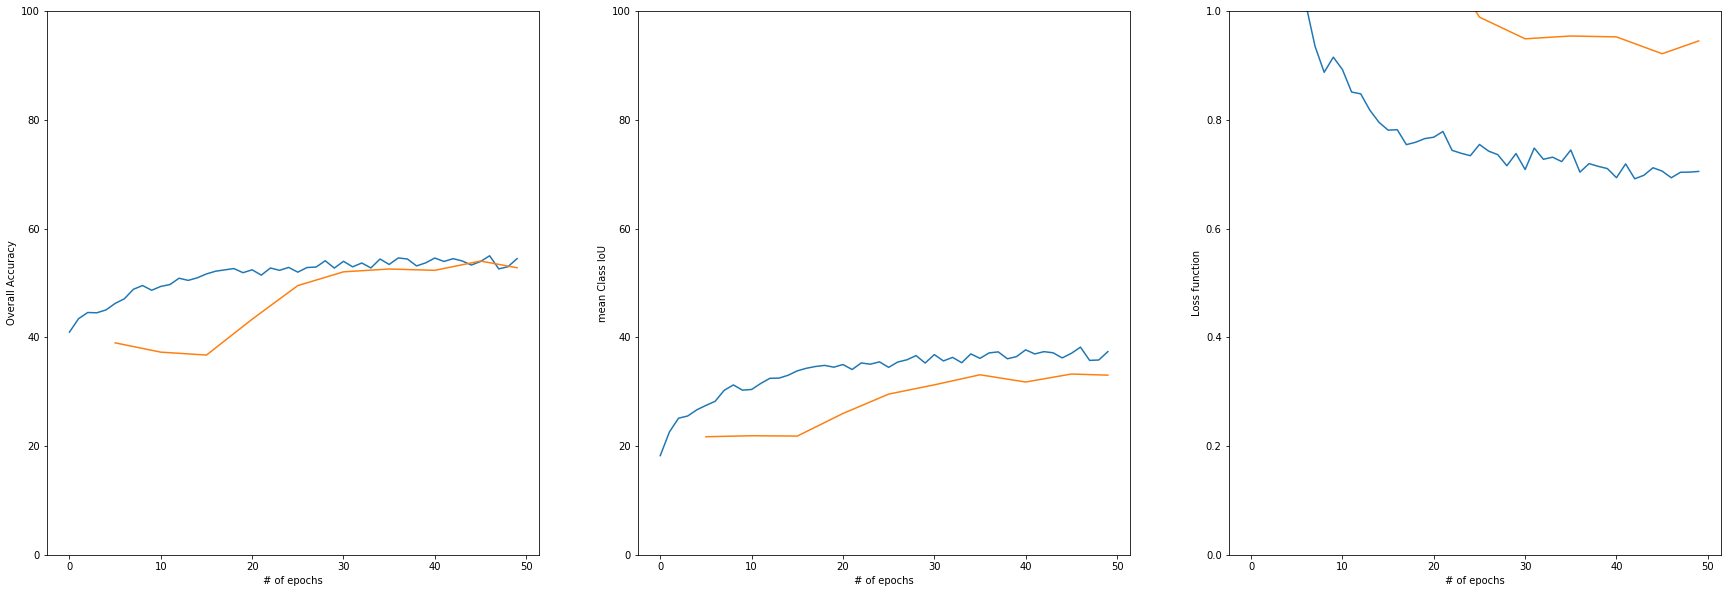

Training finished in 5096.999503850937s


In [12]:
args = mock.Mock() #stores the parameters
args.n_epoch = 50
args.n_epoch_test = int(5) #periodicity of evaluation on test set
args.batch_size = 4
args.n_class = 3
args.n_channel = 6 if use_cir and use_rgb else 3
args.conv_width = [32,32,32,32,32,32]
args.dconv_width = [32,32,32,32]
args.cuda = 0
args.lr = 5e-4

a = time()
trained_model = train_full(args)
b = time()

print('Training finished in ' + str(b-a) + 's')

In [13]:
print(X_t.shape)
print(y_t.shape)

print(X_t.max())
print(X_t.min())
print(y_t.max())
print(y_t.min())

torch.Size([20, 6, 500, 500])
torch.Size([20, 500, 500])
tensor(255.)
tensor(1.)
tensor(2)
tensor(0)


In [ ]:
print()

In [14]:
def plot_rgb_cir_gt_pred(tile_index, data, gt, model, cir, rgb):
    # Function to plot prediction vs ground truth
    
    # Plotting
    plt.figure(facecolor='white')

    data = data[tile_index,:,:,:]
    pred = model(data[None,:,:,:]).cpu().detach().numpy()
    pred = pred[0,:,:,:].argmax(0).squeeze()
    
    unique, counts = np.unique(pred, return_counts=True)
    print(dict(zip(unique, counts)))
    
    data = data.cpu().numpy().astype(np.uint8)
    
    if cir and rgb:
        plt.subplot(1, 4, 1)
        plt.imshow(data[:3].transpose([1,2,0]))
        plt.title('NIR Red Green composite')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(data[-3:].transpose([1,2,0]))
        plt.title('Red Green Blue composite')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')
    
    elif cir or rgb:
        plt.subplot(1, 3, 1)
        plt.imshow(data.transpose([1,2,0]))
        if cir:
            plt.title('NIR Red Green composite')
        else:
            plt.title('Red Green Blue composite')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt[tile_index,:,:], CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')

{0: 62307, 1: 180630, 2: 7063}


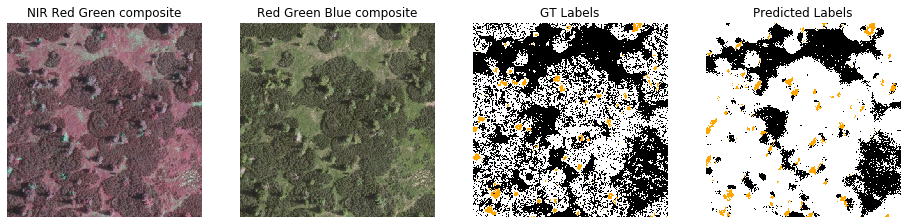

In [15]:
plot_rgb_cir_gt_pred(3, X_t, y_t, trained_model, use_cir, use_rgb)